# Libraries

In [1]:
import numpy as np
import pystan
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [2]:
# Main thread

if __name__ == '__main__':

    # Configuring paths and inputs -------------------------------------------------------------------------------------
    my_data = np.loadtxt('./../../Catalogue/binom_reg_dataset.csv', delimiter=',', dtype=str)

    my_dictionary = {}
    for i in range(len(my_data[0, :])):                                         # Converting numpy array into dictionary
         my_dictionary[my_data[0, i]] = np.array(my_data[0 + 1:, i], dtype=str)

    logit_class   = my_dictionary['LOGIT_CLASS(1-UVUP;0-UVWEAK)'].astype(int)
    redshift      = my_dictionary['Z'].astype(float)
    stellar_mass  = my_dictionary['STELLAR_MASS'].astype(float)
    
    index = np.where(redshift<=0.4)

    x1 = redshift[index]
    x2 = stellar_mass[index]
    y  = logit_class[index]                                             # whether this is a galaxy with uv upturn or not
    n_obs = x1.size

    regression_data = {}
    regression_data['K'] = 4      # number of betas
    regression_data['X'] = sm.add_constant(np.column_stack((x1, x1**2,x2)))
    # regression_data['X'] = sm.add_constant(x1)
    regression_data['N'] = n_obs
    regression_data['Y'] = y
    regression_data['LogN'] = np.log(n_obs)
    
    # Data to be plotted -------------------------------------------------------------------------------------------
#     redshift_plot = np.linspace(x1.min(), x1.max(), 1000)
#     x2 = redshift_plot
#     n_obs2 = redshift_plot.size
#     regression_data['X2'] = sm.add_constant(np.column_stack((x2, x2**2)))
#     regression_data['N2'] = n_obs2

    # Fit: STAN code ---------------------------------------------------------------------------------------------------
    stan_code = """
    data{
        int<lower=0> N;
        int<lower=0> K;
        int Y[N];
        matrix[N,K] X;
        real LogN;
    }

    parameters{
        vector[K] beta;
    }

    transformed parameters{
        vector[N] eta;
        eta = X * beta;
    }

    model{
        Y ~ bernoulli_logit(eta);
    }

    generated quantities{
        real LLi[N];
        real AIC;
        real BIC;
        real LogL;
        vector[N] etanew;
        real<lower=0, upper=1.0> pnew[N];
        etanew = X * beta;
        for (j in 1:N){
            pnew[j] = inv_logit(etanew[j]);
            LLi[j] = bernoulli_lpmf(1|pnew[j]);
        }
        LogL = sum(LLi);
        AIC = -2 * LogL + 2 * K;
        BIC = -2 * LogL + LogN * K;
    }
    """

    fit = pystan.stan(model_code=stan_code, data=regression_data, iter=7000, chains=3, warmup=3000, n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_380fcba733f6f2ec51b21114e52c2444 NOW.


In [3]:
lines = list(range(8)) + [2 * n_obs + 8, 2 * n_obs + 9, 2 * n_obs + 10]
output = str(fit).split('\n')

for i in lines:
    print(output[i])

Inference for Stan model: anon_model_380fcba733f6f2ec51b21114e52c2444.
3 chains, each with iter=7000; warmup=3000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=12000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]      -4.69    0.07   4.31 -13.13  -7.56  -4.77  -1.86   3.82 3337.0    1.0
beta[1]      21.09    0.17    9.9   2.08  14.37  21.06  27.69  40.93 3309.0    1.0
beta[2]     -41.84     0.4  23.47  -88.2 -57.79 -41.65 -25.95    3.1 3482.0    1.0
LLi[503]     -0.75  8.1e-4   0.06  -0.89  -0.79  -0.75  -0.71  -0.63 6371.0    1.0
AIC         925.36    0.53  56.88 818.73 886.77 923.27 962.99 1043.0  11418    1.0
BIC         942.25    0.53  56.88 835.62 903.66 940.16 979.88 1059.9  11418    1.0


In [4]:
output = str(pystan.misc._print_stanfit(fit, digits_summary=4)).split('\n')

In [5]:
posteriors = list(fit.extract(u'beta').items()[0])

In [6]:
betas = posteriors[1]

In [7]:
print betas.shape

(12000, 4)


In [8]:
beta0 = betas[:,0]
beta1 = betas[:,1]
beta2 = betas[:,2]
beta3 = betas[:,3]

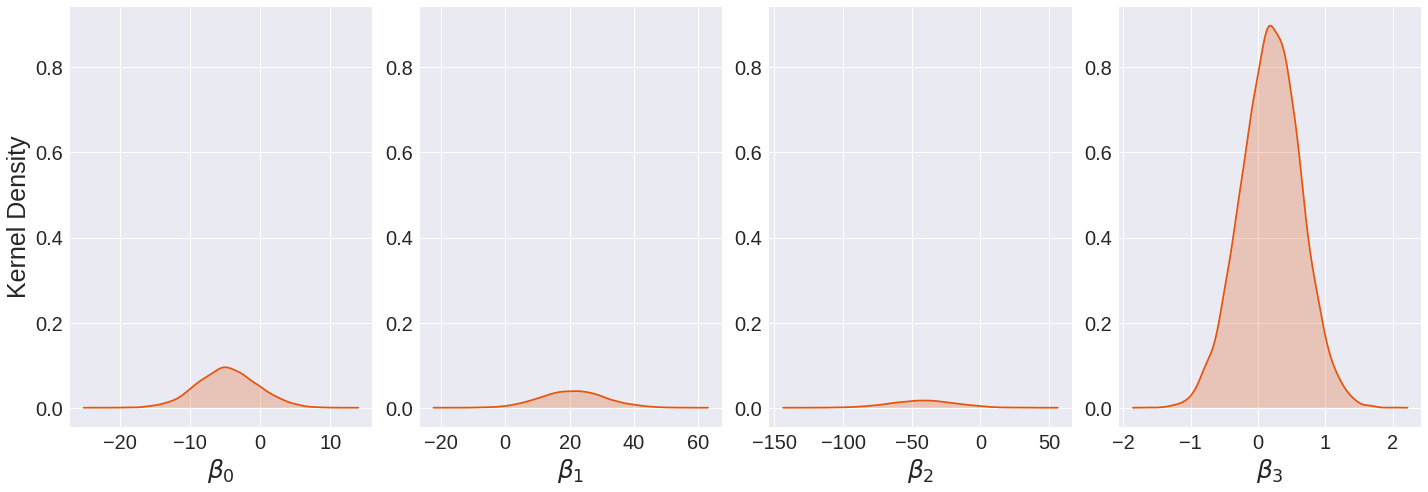

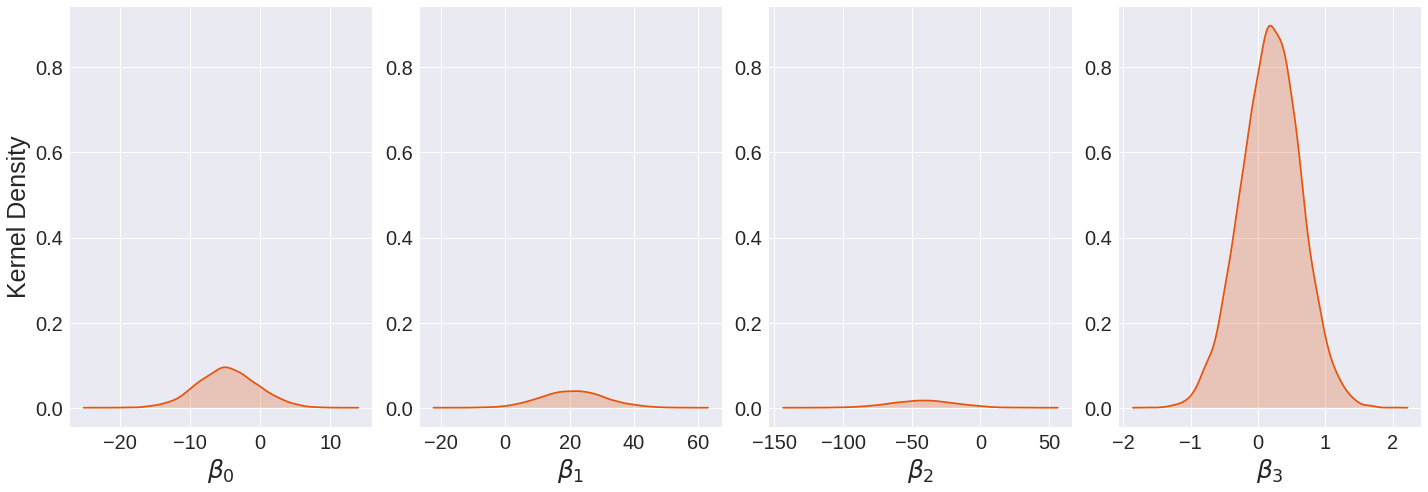

In [10]:
plt.subplots(1,1, figsize=(20,7), sharey=True)

plot01 = plt.subplot(1,4,1)
sns.kdeplot(beta0, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{0}$", fontsize=25)
plt.ylabel(r"Kernel Density", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.subplot(1,4,2, sharey=plot01)
sns.kdeplot(beta1, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{1}$", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.subplot(1,4,3, sharey=plot01)
sns.kdeplot(beta2, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{2}$", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.subplot(1,4,4, sharey=plot01)
sns.kdeplot(beta3, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{3}$", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.tight_layout()
plt.savefig('./Results//posterios_sharey_3d.pdf', dpi=100)
plt.show()

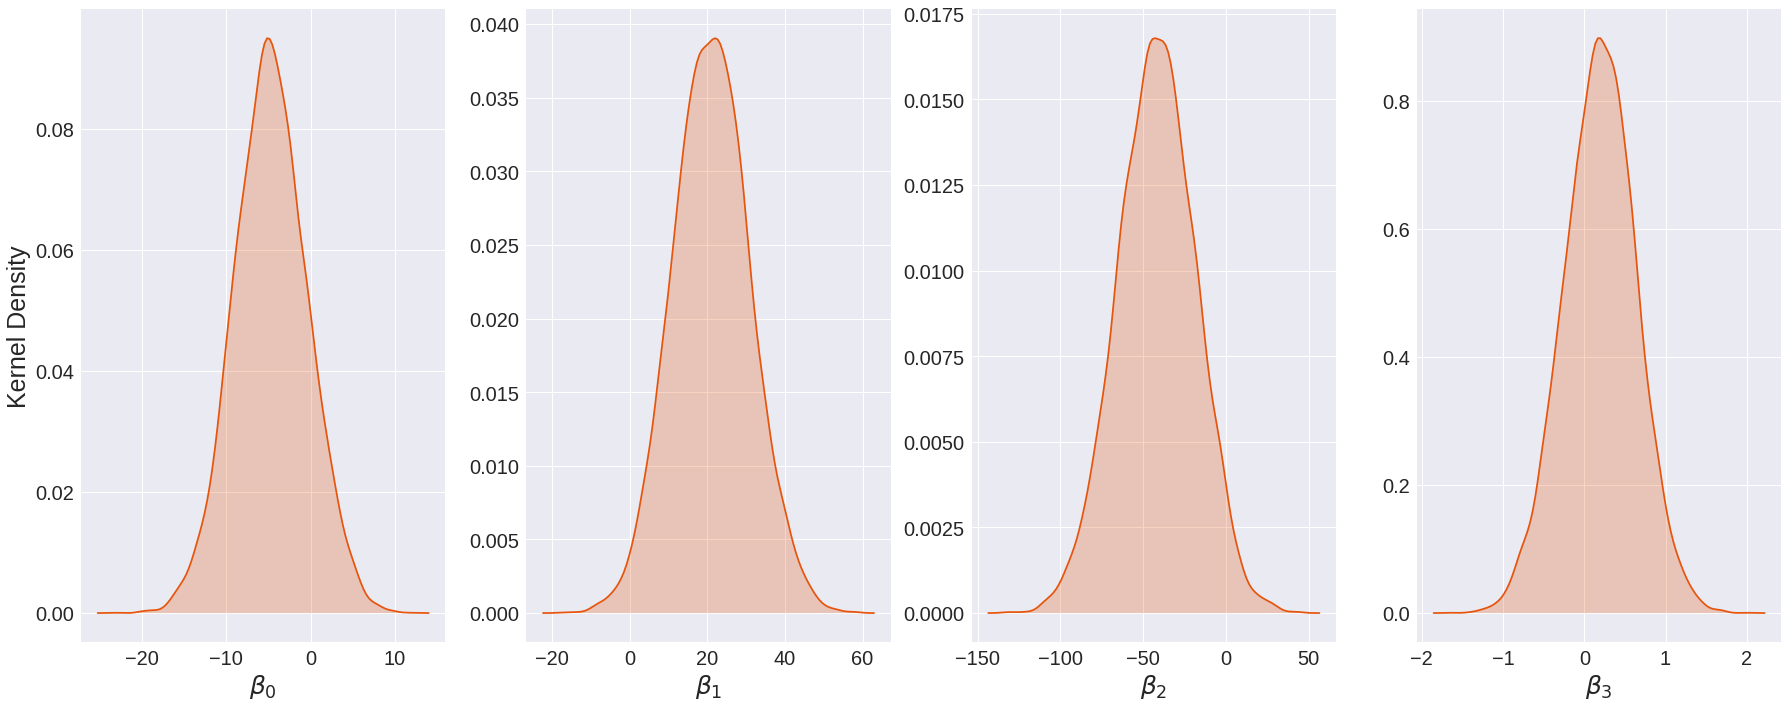

In [11]:
plt.subplots(1,1, figsize=(25,10), sharey=True)

plot01 = plt.subplot(1,4,1)
sns.kdeplot(beta0, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{0}$", fontsize=25)
plt.ylabel(r"Kernel Density", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.subplot(1,4,2)
sns.kdeplot(beta1, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{1}$", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.subplot(1,4,3)
sns.kdeplot(beta2, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{2}$", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.subplot(1,4,4)
sns.kdeplot(beta3, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{3}$", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.tight_layout()
plt.savefig('./Results/posterios_3d.pdf', dpi=100)
plt.show()

In [12]:
output = np.array(output)

In [13]:
new_output = output[5:-6] #removing header and footer
print new_output.shape
print new_output.size
print new_output[0].split()[0]

(2023,)
2023
beta[0]


In [14]:
for i in range(new_output.size):
    print new_output[i]
# print new_output[-1]
# print new_output[9610]
# print new_output[-2]
# print new_output[4725].split()[1][0:6]
# print new_output[4725].split()[1][6:]

beta[0]     -4.686  0.0746 4.3075 -13.12 -7.564 -4.770 -1.855 3.8249   3337 1.0004
beta[1]     21.092  0.1721 9.9015 2.0816 14.367 21.057 27.688 40.931   3309 1.0009
beta[2]     -41.83  0.3978 23.470 -88.19 -57.78 -41.65 -25.95 3.0956   3482  1.001
beta[3]     0.1924  0.0078 0.4447 -0.704 -0.103  0.197 0.4918  1.056   3239 1.0003
eta[0]      -0.673  0.0034 0.2149 -1.094 -0.819 -0.671 -0.527 -0.255   3951 1.0002
eta[1]      -0.488  0.0017 0.1381 -0.765 -0.580 -0.489 -0.394 -0.223   6979    1.0
eta[2]      -0.207  0.0014 0.1205 -0.443 -0.288 -0.206 -0.127 0.0291   7202 1.0006
eta[3]      -0.102   0.002  0.138 -0.375 -0.193 -0.104 -0.010 0.1652   4762 1.0007
eta[4]      -0.386  0.0024 0.1584 -0.698 -0.493 -0.386 -0.278 -0.080   4263 1.0004
eta[5]      -0.281  0.0013 0.1144 -0.507 -0.357 -0.281 -0.204 -0.057   7444 1.0005
eta[6]      0.0393  0.0017 0.1389 -0.234 -0.052 0.0397 0.1307 0.3122   6653 1.0007
eta[7]      0.0027  0.0035 0.2923 -0.571 -0.194 0.0042 0.2004 0.5689   6923 1.0002
eta[

pnew[490]   0.4102  0.0013 0.0763 0.2678 0.3569 0.4074 0.4604  0.565   3313 1.0004
pnew[491]   0.2123  0.0007 0.0471 0.1298 0.1782 0.2094 0.2432 0.3114   4580 1.0006
pnew[492]   0.3766  0.0003 0.0305 0.3166 0.3559  0.376 0.3972 0.4366   7910 0.9999
pnew[493]   0.5131  0.0007 0.0622 0.3906 0.4704 0.5135 0.5563 0.6327   7551 1.0001
pnew[494]    0.455  0.0005  0.033 0.3903 0.4333 0.4545 0.4771 0.5191   4888 1.0007
pnew[495]   0.3226  0.0003 0.0303 0.2639 0.3021 0.3224 0.3432 0.3817   8623 0.9999
pnew[496]    0.428  0.0004 0.0299 0.3694  0.408 0.4278 0.4481 0.4868   5820 1.0005
pnew[497]   0.4558  0.0006 0.0368 0.3844 0.4311 0.4554 0.4805 0.5275   4301 1.0006
pnew[498]   0.4254  0.0005 0.0366 0.3539 0.4003 0.4257 0.4499 0.4971   5702 1.0003
pnew[499]   0.5192  0.0004 0.0329  0.454 0.4971 0.5192 0.5411 0.5841   8634 1.0005
pnew[500]   0.4559  0.0019 0.1308 0.2112  0.362 0.4518 0.5483 0.7133   4507 1.0006
pnew[501]   0.5054  0.0006 0.0422 0.4219  0.477 0.5063 0.5335  0.589   4623 1.0006
pnew

In [15]:
print new_output.shape

(2023,)


In [16]:
diagnostics = []
idx_problem = []
for i in range(new_output.size):
    if len(new_output[i].split())<11:
        print i, len(new_output[i].split()),'\n'
        print new_output[i].split(), len(new_output[i].split())
        idx_problem.append(i)
        diagnostics.append(len(new_output[i].split()))
    else:
        continue
print np.unique(diagnostics)
print idx_problem

1012 7 

['AIC', '9.254e2', '0.5323', '56.8758.187e28.868e29.233e2', '9.63e21.043e3', '11418', '0.9999'] 7
1013 7 

['BIC', '9.423e2', '0.5323', '56.8758.356e29.037e29.402e29.799e2', '1.06e3', '11418', '0.9999'] 7
1014 6 

['LogL', '-4.587e2', '0.2661', '28.437-5.175e2-4.775e2-4.576e2-4.394e2-4.054e2', '11418', '0.9999'] 6
[6 7]
[1012, 1013, 1014]


In [17]:
header_fit = output[4].split()
print header_fit

['mean', 'se_mean', 'sd', '2.5%', '25%', '50%', '75%', '97.5%', 'n_eff', 'Rhat']


In [18]:
header_addendum = 'parameter'
header_fit = [header_addendum] + header_fit
print header_fit

['parameter', 'mean', 'se_mean', 'sd', '2.5%', '25%', '50%', '75%', '97.5%', 'n_eff', 'Rhat']


In [19]:
# this is to fix lines where numbers are not separated - this is a manual action, must change everytime you rerun
print idx_problem
print new_output[idx_problem]

[1012, 1013, 1014]
[ 'AIC        9.254e2  0.5323 56.8758.187e28.868e29.233e2 9.63e21.043e3  11418 0.9999'
 'BIC        9.423e2  0.5323 56.8758.356e29.037e29.402e29.799e2 1.06e3  11418 0.9999'
 'LogL       -4.587e2  0.2661 28.437-5.175e2-4.775e2-4.576e2-4.394e2-4.054e2  11418 0.9999']


In [20]:
new_output[1012] = 'AIC   9.254e2 0.5323 56.875  8.187e2  8.868e2  9.233e2  9.63e2   1.043e3 11418 0.9999'
new_output[1013] = 'BIC   9.423e2 0.5323 56.875  8.356e2  9.037e2  9.402e2  9.799e2  1.06e3  11418 0.9999'
new_output[1014] = 'LogL -4.587e2 0.2661 28.437 -5.175e2 -4.775e2 -4.576e2 -4.394e2 -4.054e2 11418 0.9999'

In [21]:
new_data = header_fit
for i in range(new_output.size):
    if len(new_output[i].split())!=11: #the length of the list must be 11, in which case we connect them directly
        print "there is a problem!"
    else:
        new_output_i = np.array(new_output[i].split()).reshape(1,11)
        new_data = np.vstack((new_data, new_output_i))

In [22]:
import pandas as pd

In [23]:
new_dataframe = pd.DataFrame(new_data)
new_dataframe.to_csv('./Results/logit_3d.csv', sep=',', header=False, index=False)

In [24]:
print new_data.shape
print new_data[-1]

(2024, 11)
['pnew[503]' '0.472' '0.0004' '0.0305' '0.4121' '0.4517' '0.4719' '0.4924'
 '0.5319' '6350' '1.0008']


In [25]:
betas = {}
betas['beta0'] = beta0
betas['beta1'] = beta1
betas['beta2'] = beta2
betas['beta3'] = beta3

In [26]:
betas_dataframe = pd.DataFrame(betas)
betas_dataframe.to_csv('./Results/betas_3d.csv', sep=',', header=True, index=False)

In [27]:
pnew = list(fit.extract(u'pnew').items()[0])

In [28]:
model_results = {}
model_results['pnew'] = pnew[1][0]
model_results['redshift'] = x1
model_results['stellar_mass'] = x2

In [29]:
model_dataframe = pd.DataFrame(model_results)
model_dataframe.to_csv('./Results/model_prob_3d.csv', sep=',', header=True, index=False)